In [69]:
import cProfile
import functools
import geopy
import itertools
import json
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests
import scipy as sp
import rtree
import seaborn as sb
from scipy import signal
# import shapely
import shapely.geometry
%pylab inline
import data_munging

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
rides, readings = data_munging.read_raw_data()
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

In [3]:
reload(data_munging)

<module 'data_munging' from 'data_munging.pyc'>

In [4]:
chi_readings = data_munging.filter_readings_to_chicago(readings)

In [5]:
chi_readings = data_munging.filter_to_good_readings(chi_readings)

In [6]:
print rides.shape
print readings.shape
n, p = readings.shape

(94, 7)
(35884, 41)


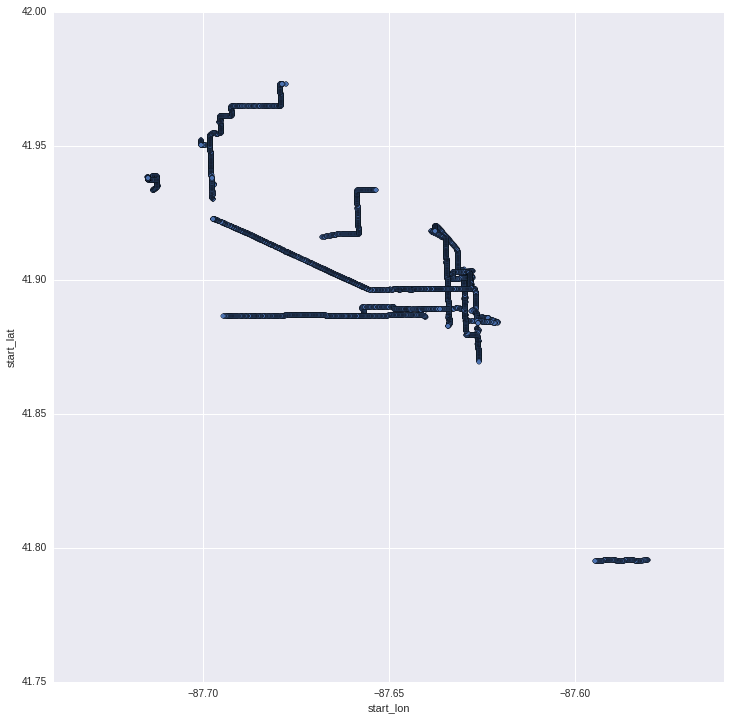

In [7]:
chi_readings.plot(x='start_lon', y='start_lat', kind='scatter')
config = plt.gcf()
config.set_size_inches(12, 12)
plt.show()

In [9]:
max_lat = np.max(chi_readings['start_lat'])
max_lon = np.max(chi_readings['start_lon'])
min_lat = np.min(chi_readings['start_lat'])
min_lon = np.min(chi_readings['start_lon'])

In [10]:
max_x = np.max(chi_readings['start_x'])
max_y = np.max(chi_readings['start_y'])
min_x = np.min(chi_readings['start_x'])
min_y = np.min(chi_readings['start_y'])

In [11]:
x_range = max_x - min_x
y_range = max_y - min_y

In [12]:
data_munging.calc_dist(max_lon, max_lat, min_lon, min_lat)

22721.4660271753

In [13]:
north_south_meters = data_munging.calc_dist(max_lon, max_lat, min_lon, max_lat)
east_west_meters = data_munging.calc_dist(max_lon, max_lat, max_lon, min_lat)
print north_south_meters
print east_west_meters

11147.3459941
19790.2951188


In [14]:
patch_size = 5

In [15]:
north_south_patches = int(np.ceil(north_south_meters / patch_size))
east_west_patches = int(np.ceil(east_west_meters / patch_size))

In [16]:
x_step = x_range / east_west_patches
y_step = y_range / north_south_patches

In [17]:
rastered_pavement_quality = np.zeros((north_south_patches, east_west_patches))

In [18]:
readings_idx = data_munging.insert_readings_rtree(chi_readings)

In [19]:
chi_readings['abs_mean_over_speed'] = (chi_readings['abs_mean_total'] /
                                       chi_readings['gps_speed'])

In [21]:
total_itrs = 0
for i, j in itertools.product(range(north_south_patches), range(east_west_patches)):
    total_itrs += 1
    if total_itrs % 1000000 == 0:
        print total_itrs
    patch_bb = (min_x + x_step * j, min_y + y_step * i,
                min_x + x_step * (j + 1), min_y + y_step * (i + 1))
    segs_in_patch = list(readings_idx.intersection(patch_bb))
    if len(segs_in_patch) > 0:
        rastered_pavement_quality[i, j] = np.mean(chi_readings['abs_mean_over_speed'][segs_in_patch])

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000


In [22]:
print north_south_patches
print east_west_patches

2230
3959


In [23]:
print north_south_patches * east_west_patches

8828570


In [26]:
for i, j in itertools.product(range(north_south_patches), range(east_west_patches)):
    patch_bb = (min_x + x_step * j, min_y + y_step * i,
                min_x + x_step * (j + 1), min_y + y_step * (i + 1))
    segs_in_patch = list(readings_idx.intersection(patch_bb))
    pavement_quality = 0
    if len(segs_in_patch) > 0:
        pavement_quality = np.mean(chi_readings['abs_mean_over_speed'][segs_in_patch])
    rastered_pavement_quality[i, j] = pavement_quality

In [65]:
def row_to_str(row):
    return functools.reduce(lambda x, y: x + ' ' + y, [str(int(i * 10)) for i in row])

In [67]:
data_munging.data_dir

'/home/zblan/Dropbox/project-pavement/pavement_analysis/src/../dat/'

In [66]:
with open(data_munging.data_dir + 'rastered_chicago.asc', 'w+') as f:
    for i in range(rastered_pavement_quality.shape[0]):
        f.write(row_to_str(rastered_pavement_quality[i, :]))   

In [78]:
with open(data_munging.data_dir + 'raster_metadata.txt', 'w+') as f:
    metadata = {'lon_min': min_lon,
                'lon_max': max_lon,
                'lat_min': min_lat,
                'lat_max': max_lat,
                'nrows': rastered_pavement_quality.shape[0],
                'ncols': rastered_pavement_quality.shape[1]
               }
    json.dump(metadata, f)

In [90]:
print np.max(rastered_pavement_quality.flat)
print np.mean(rastered_pavement_quality.flat == 0)

1.12770514545
0.998658446385


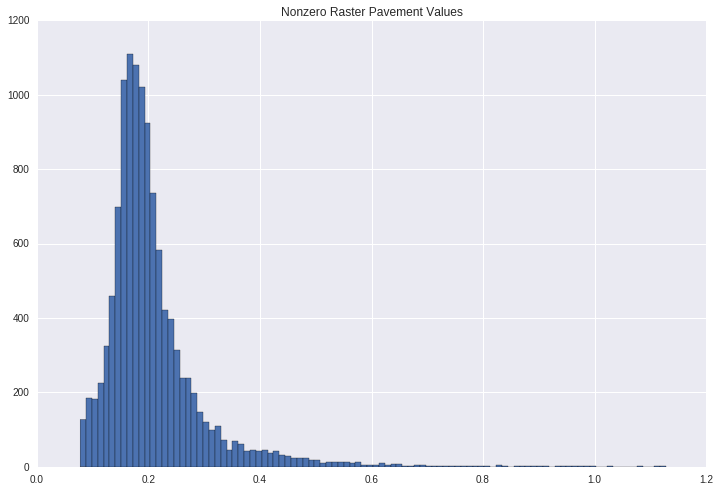

In [89]:
plt.hist(rastered_pavement_quality.flat[rastered_pavement_quality.flat > 0], bins=100)
plt.title('Nonzero Raster Pavement Values')
gcf = plt.gcf()
gcf.set_size_inches((12, 8))

In [ ]:
chi_readings.plot(x='start_x', y='start_y', kind='scatter')
plt.plot([patch_bb[0], patch_bb[2] + 5000],
         [patch_bb[1], patch_bb[3] + 2000], color='red')
config = plt.gcf()
config.set_size_inches(12, 12)
plt.show()